### Imports

In [121]:
import numpy as np
import numpy.random as rnd
import PIL.Image as img
import PIL.ImageDraw as imgdr

### Parameters

In [142]:
source_image = img.open("./source_img.png")

generation_size = 100
max_generation_cycles = 500

mutation_chance = 0.5
mutation_speed = 10.0
selection_percent = 0.8


### Image Utils

In [96]:
def distance(image1,image2):
    return np.sum(np.absolute(image2 - image1))

def get_random_color(transparency = np.random.randint(255)):
    return (np.random.randint(255), np.random.randint(255),np.random.randint(255),transparency)

### Chromosome

0.0006010801289701568


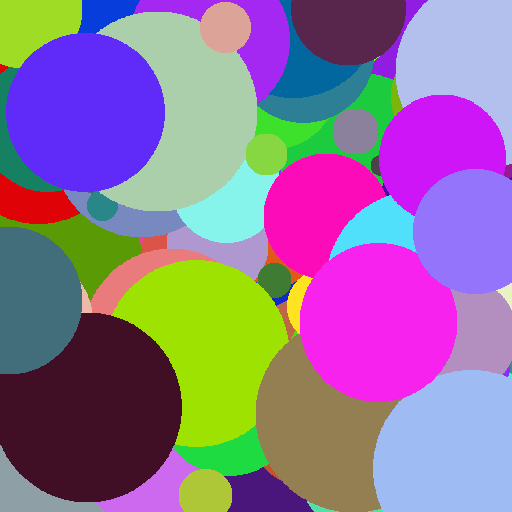

In [140]:
class Gene:
    
    @staticmethod
    def generate_random():
        pass
    
    def draw_at(self,canvas):
        pass
    
    def mutate(self):
        pass
        
class CircleGene:
    
    def __init__(self,x,y,radius,color):
        self.x, self.y = x, y
        self.radius = radius
        self.color = color
        self.fitness = -1
        
    def draw_at(self,canvas):
        x, y = self.x, self.y
        r, c = self.radius, self.color
        canvas.ellipse((x-r,y-r,x+r,y+r),fill=c)
        
    def mutate(self):
        self.x += (rnd.rand()-0.5 ) * 5 * mutation_speed
        self.y += (rnd.rand()-0.5 ) * 5 * mutation_speed
        self.radius += (rnd.rand()-0.5) * 40 * mutation_speed
        self.color = get_random_color()
        
    @staticmethod
    def generate_random(image):
        w,h = image.size
        x = np.random.uniform(0,w)
        y = np.random.uniform(0,h)
        r = np.random.uniform(0,100)
        gene = CircleGene(x,y,r,get_random_color())
        return gene
        
        
class Chromosome:
    
    def __init__(self,genes = [],genes_count = 600):
        self.genes = genes
        self.fitness = -1
        self.genes_count = genes_count
        
    @staticmethod
    def generate_random(image,genes_count=600):
        chromosome = Chromosome(genes_count=genes_count)
        for i in range(chromosome.genes_count):
            gene = CircleGene.generate_random(image)
            chromosome.genes.append(gene)
        return chromosome
    
    def get_fitness(self,target_image):
        if self.fitness != -1:
            return self.fitness
        w,h = target_image.size
        self.image = img.fromarray(np.zeros((w,h,4)).astype('uint8'))
        canvas = imgdr.Draw(self.image, 'RGBA')
        for i in range(self.genes_count):
            self.genes[i].draw_at(canvas)
        dist = distance(np.array(target_image),np.array(self.image))
        return 100000/(100000 + dist)
            
    
ch = Chromosome.generate_random(source_image)
print(ch.get_fitness(source_image))
ch.image

### GA

In [141]:
def mutate(chromosome):
    r = rnd.rand()
    if r >= mutation_chance: 
        return
    chromosome.fitness = -1
    index = rnd.randint(0, chromosome.genes_count)
    chromosome.genes[index].mutate()
    chromosome.get_fitness(source_image)

def crossover(chromosome1,chromosome2):
    if chromosome1.genes_count != chromosome2.genes_count:
        return (chromosome1,chromosome2)
    int crossover_point = rnd.randint(chromosome1.genes_count)
    for i in range(crossover_point);
        chromosome1.genes[i], chromosome2.genes[i] = chromosome2.genes[i], chromosome1.genes[i];
    return (chromosome1, chromosome2)

def select(chromosome1):
    pass

ch = Chromosome.generate_random(source_image,genes_count=10)
print(ch.get_fitness(source_image))
ch.image.show()
mutate(ch)
ch.image.show()
mutate(ch)

0.001123159240281612


### Main

In [11]:
def __init__(self):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-11-2614a9931e91>, line 2)